In [1]:
import xarray as xr
from glob import glob
from datetime import datetime
import yaml
import sys
sys.path.append('../../')

import plotting

from ecco_pipeline.baseclasses import Grid
from ecco_pipeline.conf.global_settings import OUTPUT_DIR
from ecco_pipeline.utils.pipeline_utils.file_utils import get_date
from ecco_pipeline.transformations.grid_transformation import Transformation

In [2]:
ds_name = "SMAP_RSS_L3_SSS_SMI_MONTHLY_V4"
hemisphere = ''
with open(f'conf/ds_configs/{ds_name}.yaml', 'r') as stream:
    config = yaml.load(stream, yaml.Loader)

# Load sample granule

In [3]:
ds_granules_dir = f'{OUTPUT_DIR}/{ds_name}/harvested_granules/'
ds_granules = glob(f'{ds_granules_dir}/**/*.nc*')
if hemisphere:
    ds_granules = [g for g in ds_granules if hemisphere in g]
sample_granule_path = ds_granules[0]
print(sample_granule_path)

/Users/marlis/Developer/ECCO/ecco_output/SMAP_RSS_L3_SSS_SMI_MONTHLY_V4/harvested_granules/2015/RSS_smap_SSS_L3_monthly_2015_05_FNL_v04.0.nc


In [4]:
filename_date_str = get_date(config['filename_date_regex'], sample_granule_path.split('/')[-1])
granule_date = datetime.strptime(filename_date_str, config['filename_date_fmt']).strftime('%Y-%m-%dT%H:%M:%SZ')
ds = xr.open_dataset(sample_granule_path)
ds

<xarray.Dataset>
Dimensions:               (lon: 1440, lat: 720, time: 1)
Coordinates:
  * lon                   (lon) float32 0.125 0.375 0.625 ... 359.4 359.6 359.9
  * lat                   (lat) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * time                  (time) datetime64[ns] 2015-05-16T11:59:59.500000
Data variables:
    nobs                  (lat, lon) float64 ...
    nobs_40km             (lat, lon) float64 ...
    sss_smap              (lat, lon) float32 ...
    sss_smap_uncertainty  (lat, lon) float32 ...
    sss_smap_40km         (lat, lon) float32 ...
    sss_ref               (lat, lon) float32 ...
    gland                 (lat, lon) float32 ...
    fland                 (lat, lon) float32 ...
    gice                  (lat, lon) float32 ...
    surtep                (lat, lon) float32 ...
Attributes: (12/59)
    Conventions:                                    CF-1.6, ACDD-1.3
    standard_name_vocabulary:                       CF Standard Name Table v27
    title:                                          SMAP ocean surface salinity
    version:                                        V4.0 Validated Release
    processing_level:                               L3
    resolution:                                     Spatial resolution: appro...
    ...                                             ...
    qc_exclusions:                                  discard observations if o...
    Source of SMAP SSS:                             Meissner, T., F. Wentz, A...
    Source of  ancillary reference SSS from HYCOM:  Hybrid Coordinate Ocean M...
    Source of ancillary SST:                        Canada Meteorological Cen...
    Source of ancillary AMSR2 sea ice mask:         RSS AMSR2 sea-ice mask. W...
    Source of ancillary land mask:                  1 km land/water mask from...

# Load grid

In [5]:
grids = glob('grids/*.nc*')
grids.sort()
f'Available grids: {grids}'

"Available grids: ['grids/ECCO_llc270.nc', 'grids/ECCO_llc90.nc', 'grids/TPOSE.nc', 'grids/polar_stereo_n_25km.nc']"

In [6]:
grid_ds = xr.open_dataset(grids[1])
target_grid = Grid(grid_ds)
target_grid.ds

<xarray.Dataset>
Dimensions:                (tile: 13, j: 90, i: 90)
Coordinates:
  * tile                   (tile) int16 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j                      (j) int16 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
  * i                      (i) int16 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
Data variables:
    XC                     (tile, j, i) float32 ...
    YC                     (tile, j, i) float32 ...
    effective_grid_radius  (tile, j, i) float32 ...
Attributes:
    name:                  ECCO_llc90
    type:                  llc
    geospatial_lat_min:    -89.873055
    geospatial_lat_max:    89.739395
    geospatial_lon_min:    -179.98895
    geospatial_lon_max:    179.98691
    geospatial_lat_units:  degrees_north
    geospatial_lon_units:  degrees_east

In [7]:
T = Transformation(config, sample_granule_path, granule_date)

# Make mapping factors

In [8]:
factors = T.make_factors(target_grid)

Only using 100 nearest neighbours, but you may need up to 6375938
Creating ECCO_llc90 mapping factors...done.


# Transformation

In [9]:
field_ds_list = T.transform(target_grid, factors, ds)

In [10]:
field_ds = field_ds_list[0][0]
field_ds

<xarray.Dataset>
Dimensions:                                   (time: 1, tile: 13, j: 90, i: 90,
                                               nv: 2)
Coordinates:
  * time                                      (time) datetime64[ns] 2015-05-1...
  * tile                                      (tile) int16 0 1 2 3 ... 10 11 12
  * j                                         (j) int16 0 1 2 3 ... 86 87 88 89
  * i                                         (i) int16 0 1 2 3 ... 86 87 88 89
    XC                                        (tile, j, i) float32 -111.6 ......
    YC                                        (tile, j, i) float32 -88.24 ......
    time_bnds                                 (time, nv) datetime64[ns] 2015-...
Dimensions without coordinates: nv
Data variables:
    sss_smap_40km_interpolated_to_ECCO_llc90  (time, tile, j, i) float64 9.96...
Attributes:
    interpolated_grid:            ECCO_llc90
    model_grid_type:              llc
    original_dataset_title:       RSS SMAP Level 3 Sea Surface Salinity Stand...
    original_dataset_short_name:  SMAP_RSS_L3_SSS_SMI_MONTHLY_V4
    original_dataset_url:         https://podaac.jpl.nasa.gov/dataset/SMAP_RS...
    original_dataset_reference:   http://smap.jpl.nasa.gov/
    original_dataset_doi:         10.5067/SMP40-3SMCS
    interpolated_grid_id:         ECCO_llc90
    transformation_version:       1.0
    notes:

# Visualization

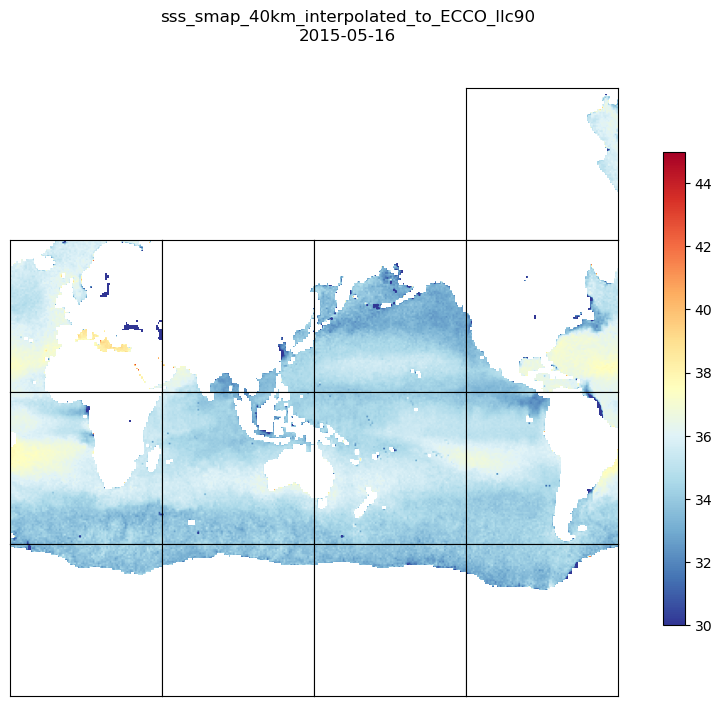

In [11]:
field_ds = field_ds_list[0]
plotting.make_plot(field_ds[0][list(field_ds[0].data_vars)[0]], vmin=30)


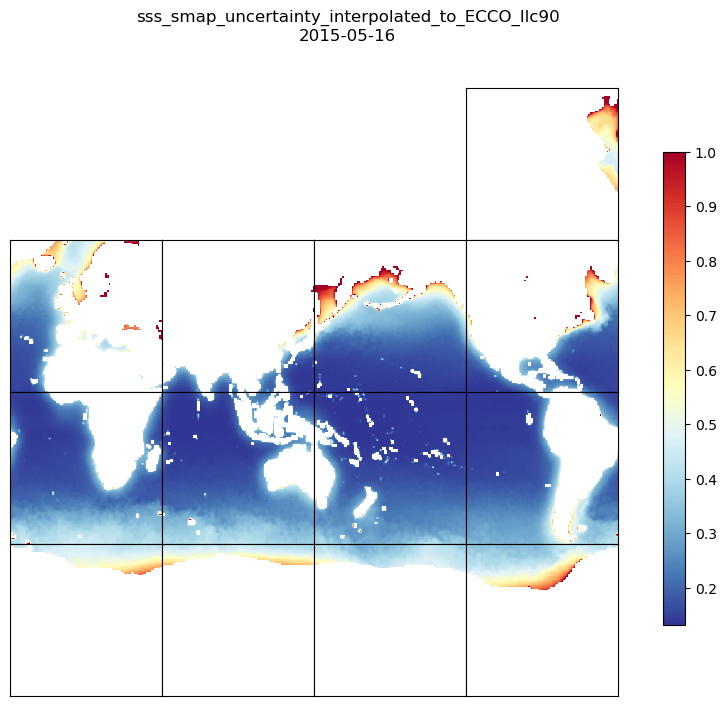

In [12]:
field_ds = field_ds_list[1]
plotting.make_plot(field_ds[0][list(field_ds[0].data_vars)[0]], vmax=1)